In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from quantizer import Quantizer
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [2]:
ABX_NB_SAMPLES = 50
QUANTIZER_ABX_DISTANCES = [
    {
        "quantized_latent": {
            "metric": "cosine",
            "weight": 1,
        }
    },
]

In [3]:
quantizers_path = glob("../out/quantizer/*/")
quantizers_path.sort()

In [4]:
quantizers_alias = {}

for quantizer_path in quantizers_path:
    quantizer = Quantizer.reload(quantizer_path, load_nn=False)
    config = quantizer.config
    
    quantizer_i = quantizer_path[-2]
    quantizer_alias = "\n".join((
        f"{','.join(config['dataset']['names'])}",
        f"hidden_layers={len(config['model']['hidden_dims'])}x{config['model']['hidden_dims'][0]}",
        f"{quantizer_i}",
    ))
    
    quantizers_alias[quantizer_alias] = quantizer_path

In [5]:
quantizers_abx_matrices = utils.pickle_load("../out/quantizer/abx_cache.pickle", {})

In [8]:
for quantizer_path in tqdm(quantizers_path):    
    if quantizer_path not in quantizers_abx_matrices:
        quantizers_abx_matrices[quantizer_path] = {}
    quantizer_abx_matrices = quantizers_abx_matrices[quantizer_path]
    
    for distance in QUANTIZER_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature not in quantizer_abx_matrices: break
    else:
        continue
    
    quantizer = Quantizer.reload(quantizer_path)
    
    main_dataset = quantizer.main_dataset
    quantizer_lab = quantizer.get_datasplit_lab(2)
    quantizer_features = quantizer.autoencode_datasplit(2)

    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)
    
    for distance in QUANTIZER_ABX_DISTANCES:
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizer_features, distance, ABX_NB_SAMPLES)
        
        quantizer_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/quantizer/abx_cache.pickle", quantizers_abx_matrices)

  0%|          | 0/459 [00:00<?, ?it/s]

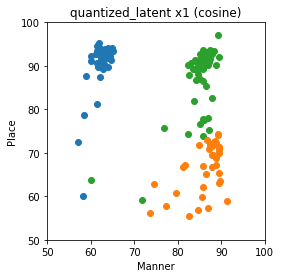

In [26]:
colors = {
    "cepstrum": "tab:orange",
    "art_params": "tab:blue",
    "cepstrum,art_params": "tab:green",
}

for distance in QUANTIZER_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    
    plt.figure()
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner")
    ax.set_ylabel("Place")
    
    ax.set_title(distance_signature)
    
    for quantizer_alias, quantizer_path in quantizers_alias.items():
        quantizer = Quantizer.reload(quantizer_path, load_nn=False)
        dataset = quantizer.main_dataset
        if ",".join(quantizer.config["dataset"]["names"]) != "pb2007":
            continue
        
        modalities = ",".join(quantizer.config["dataset"]["data_types"])
        color = colors[modalities]

        quantizer_abx_matrix = quantizers_abx_matrices[quantizer_path][distance_signature]
        quantizer_groups_score = abx_utils.get_groups_score(consonants, quantizer_abx_matrix, dataset.phones_infos["consonant_groups"])
        ax.scatter(quantizer_groups_score["manner"], quantizer_groups_score["place"], c=color)
        # raise
    
    plt.show()

In [16]:
distance = QUANTIZER_ABX_DISTANCES[0]
distance_signature = abx_utils.get_distance_signature(distance)

quantizers_loss = {
    "path": [],
    "datasets": [],
    "modalities": [],
    "hidden_layers": [],
    "num_embeddings": [],
    "embedding_dim": [],
    "dropout_p": [],
    "learning_rate": [],
    "commitment_cost": [],
    "total_loss": [],
    "reconstruction_error": [],
    "vq_loss": [],
    "abx_manner": [],
    "abx_place": [],
    "abx_global": [],
}

for quantizer_path in quantizers_path:
    quantizer = Quantizer.reload(quantizer_path, load_nn=False)
    config = quantizer.config
    
    with open("%s/metrics.pickle" % quantizer_path, "rb") as f:
        metrics = pickle.load(f)
    final_loss_index = np.argmin(metrics["validation"]["total_loss"])
    final_total_loss = metrics["test"]["total_loss"][final_loss_index]
    final_reconstruction_error = metrics["test"]["reconstruction_error"][final_loss_index]
    final_vq_loss = metrics["test"]["vq_loss"][final_loss_index]
    
    quantizers_loss["path"].append(quantizer_path[-5:])
    quantizers_loss["datasets"].append(",".join(config['dataset']['names']))
    quantizers_loss["modalities"].append(",".join(config['dataset']['data_types']))
    quantizers_loss["hidden_layers"].append(f"{len(config['model']['hidden_dims'])}x{config['model']['hidden_dims'][0]}")
    quantizers_loss["num_embeddings"].append(config['model']['num_embeddings'])
    quantizers_loss["embedding_dim"].append(config['model']['embedding_dim'])
    quantizers_loss["dropout_p"].append(config['model']['dropout_p'])    
    quantizers_loss["learning_rate"].append(config['training']['learning_rate'])
    quantizers_loss["commitment_cost"].append(config['model']['commitment_cost'])
    
    quantizers_loss["total_loss"].append(final_total_loss)
    quantizers_loss["reconstruction_error"].append(final_reconstruction_error)
    quantizers_loss["vq_loss"].append(final_vq_loss)
    
    consonants = quantizer.main_dataset.phones_infos["consonants"]
    vowels = quantizer.main_dataset.phones_infos["vowels"]
    quantizer_abx_matrix = quantizers_abx_matrices[quantizer_path][distance_signature]
    quantizer_groups_score = abx_utils.get_groups_score(consonants, quantizer_abx_matrix, dataset.phones_infos["consonant_groups"])
    quantizer_global_score = abx_utils.get_global_score(quantizer_abx_matrix)
    
    quantizers_loss["abx_manner"].append(quantizer_groups_score["manner"])
    quantizers_loss["abx_place"].append(quantizer_groups_score["place"])
    quantizers_loss["abx_global"].append(quantizer_global_score)
    
quantizers_loss = pd.DataFrame(quantizers_loss)

In [22]:
datasets = pd.unique(quantizers_loss["datasets"])
modalities = pd.unique(quantizers_loss["modalities"])

def show_top_quantizers(measure="abx_global", datasets=datasets[0], modalities=modalities[0], ascending=False):
    subset = quantizers_loss[quantizers_loss["datasets"] == datasets]
    subset = subset[subset["modalities"] == modalities]
    display(subset.sort_values(measure, ascending=ascending).head(30))

ipw.interactive(show_top_quantizers, measure=quantizers_loss, datasets=datasets, modalities=modalities, ascending=False)

interactive(children=(Dropdown(description='measure', index=14, options=('path', 'datasets', 'modalities', 'hi…